In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import skimage as ski
import bm3d
import importlib
import os
import optics as op
import seaborn as sns
from noise import gauss_noise, poisson_noise, salt_pepper_noise, mix_noise
importlib.reload(op)

<module 'optics' from 'd:\\Insti\\Internships\\Norway University\\SIM\\SIM_denoising\\optics.py'>

In [8]:
# Load the clean reference image
original = ski.color.rgb2gray(ski.io.imread('source_images/Synthetic512.png'))
clean_sim = ski.io.imread('output_images/synthetic_grated_256_sim.tif')[:, :, 0]
metric = clean_sim

# Noise types and intensity levels
noise_types = ['gaussian_noise', 'poisson_noise', 'saltpepper_noise', 'mix_noise']
intensities = ['1percent_noise', '5percent_noise', '10percent_noise', '20percent_noise']

# Filters used for denoising
filter_names = ['wiener', 'tv', 'bm3d', 'rl']
image_prefix = 'synthetic_grated_256_sim'

# Data storage
results = []

# Iterate over noise types
for noise in noise_types:
    for intensity in intensities:
        folder_path = f'output_images/{noise}/{intensity}'
        
        # Load noisy image
        noisy_image_path = os.path.join(folder_path, 'noisy_image_256_sim.tif')
        if not os.path.exists(noisy_image_path):
            continue  # Skip if noisy image is missing
        
        noisy_sim = ski.io.imread(noisy_image_path)[:, :, 0]
        
        # Compute PSNR and SSIM for noisy image
        noisy_PSNR = ski.metrics.peak_signal_noise_ratio(metric, noisy_sim)
        noisy_SSIM = ski.metrics.structural_similarity(metric, noisy_sim, data_range=1)
        
        results.append([noise, intensity, 'Noisy', noisy_PSNR, noisy_SSIM])
        
        # Compute for each filter
        for filter_type in filter_names:
            filter_image_path = os.path.join(folder_path, f'{filter_type}_{image_prefix}.tif')
            if os.path.exists(filter_image_path):
                filtered_sim = ski.io.imread(filter_image_path)[:, :, 0]
                
                psnr_value = ski.metrics.peak_signal_noise_ratio(metric, filtered_sim)
                ssim_value = ski.metrics.structural_similarity(metric, filtered_sim, data_range=1)
                
                results.append([noise, intensity, filter_type, psnr_value, ssim_value])

# Convert results into a DataFrame
df = pd.DataFrame(results, columns=['Noise Type', 'Intensity', 'Filter', 'PSNR', 'SSIM'])

# Save results
df.to_csv('output_images/denoising_results.csv', index=False)

# Display results
display(df)


,Noise Type,Intensity,Filter,PSNR,SSIM
0,gaussian_noise,1percent_noise,Noisy,38.296449,0.849776
1,gaussian_noise,1percent_noise,wiener,41.709911,0.906785
2,gaussian_noise,1percent_noise,tv,38.296359,0.849767
3,gaussian_noise,1percent_noise,bm3d,38.304899,0.850126
4,gaussian_noise,1percent_noise,rl,41.745456,0.907246
...,...,...,...,...,...
75,mix_noise,20percent_noise,Noisy,37.658662,0.756862
76,mix_noise,20percent_noise,wiener,39.753759,0.779664
77,mix_noise,20percent_noise,tv,37.658640,0.756864
78,mix_noise,20percent_noise,bm3d,37.659474,0.756949


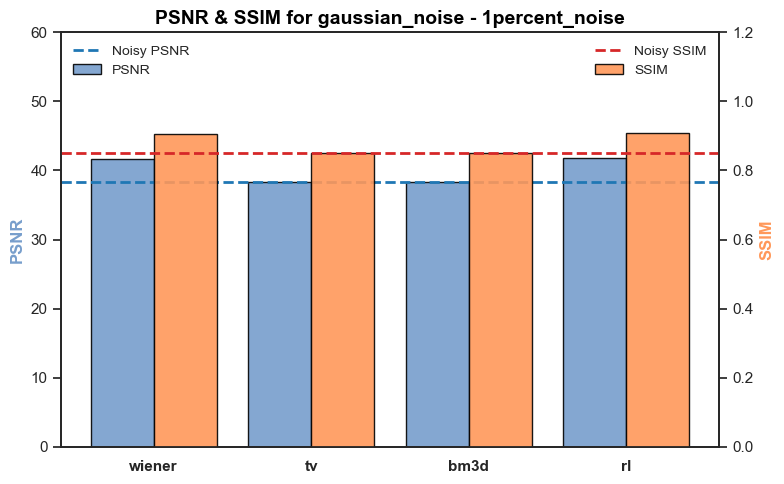

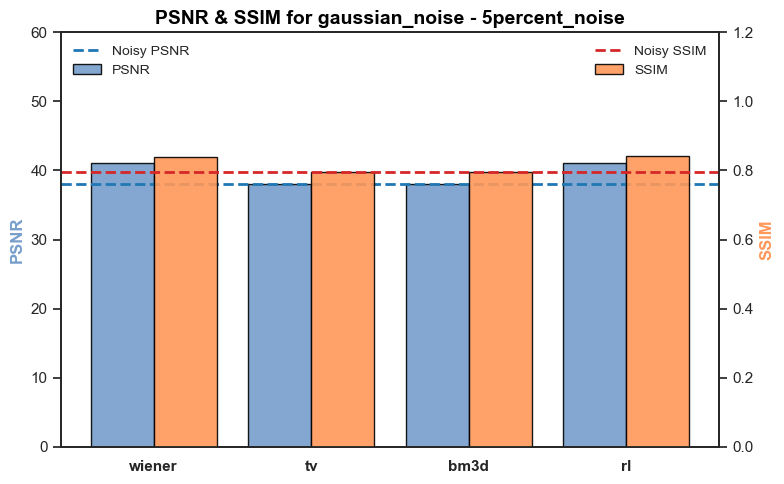

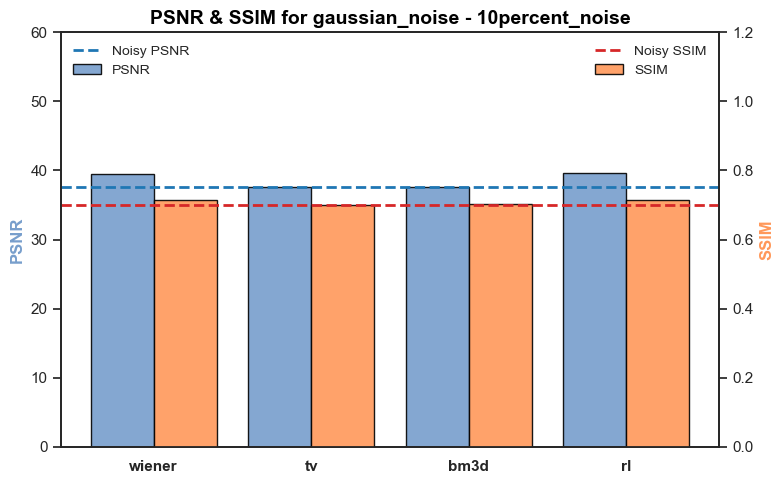

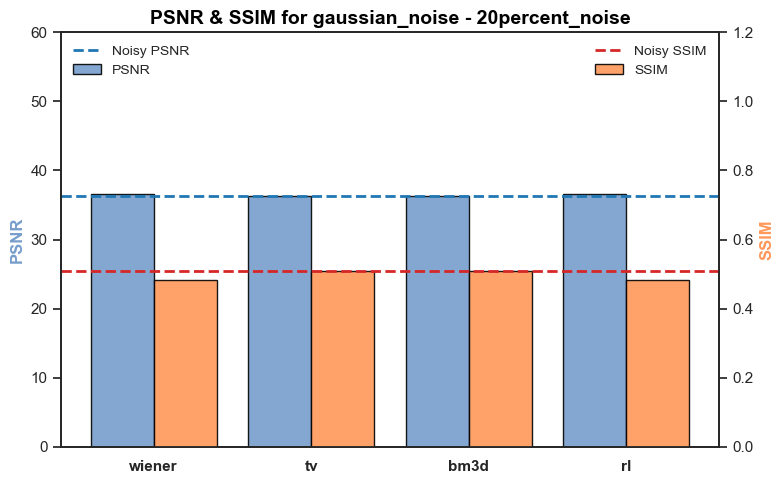

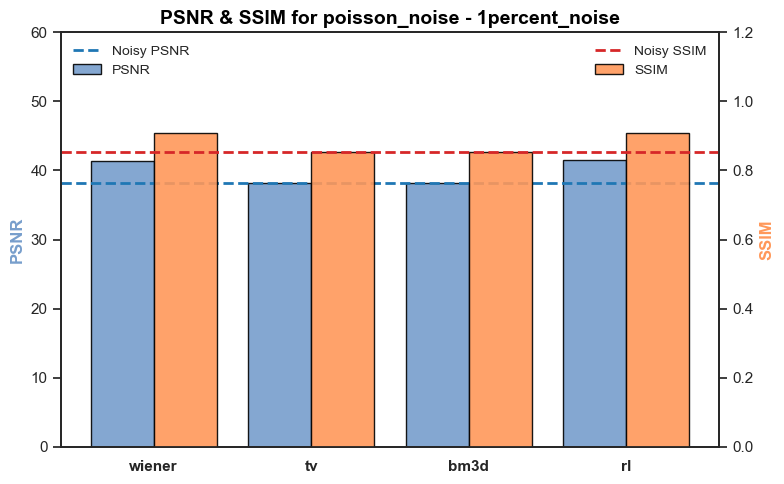

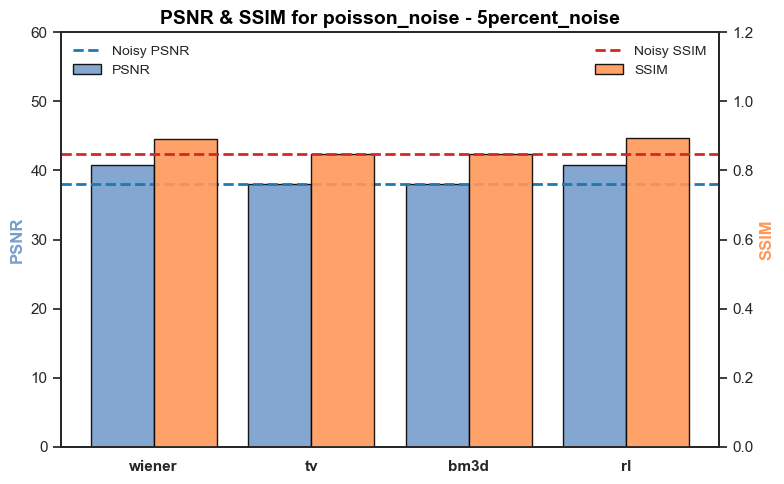

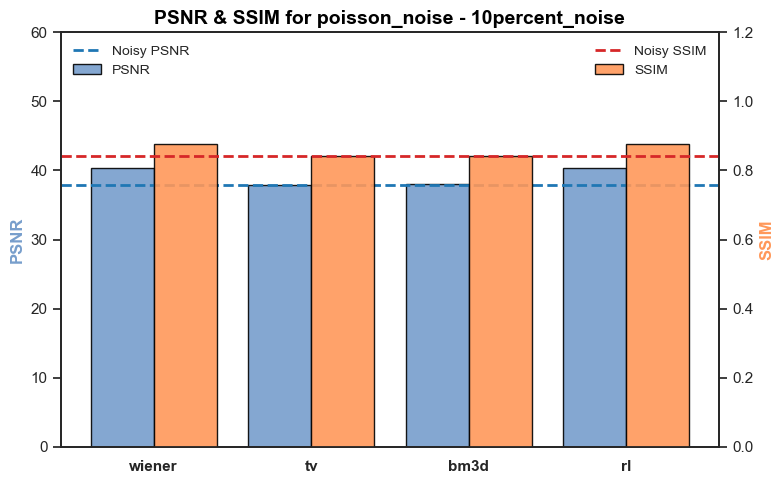

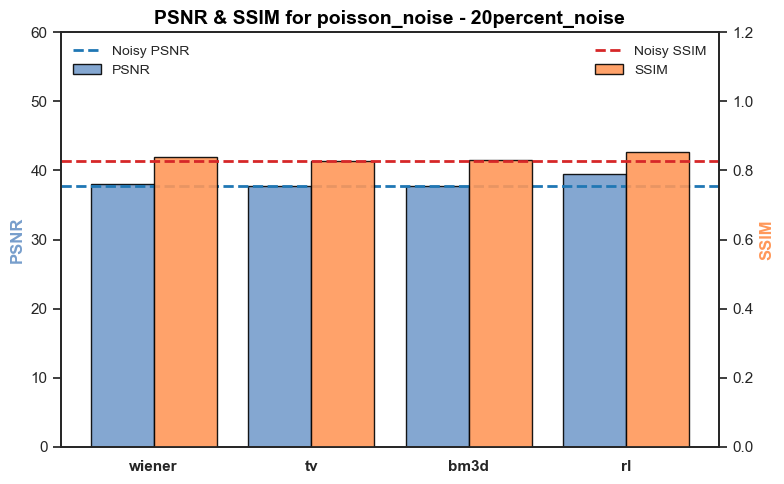

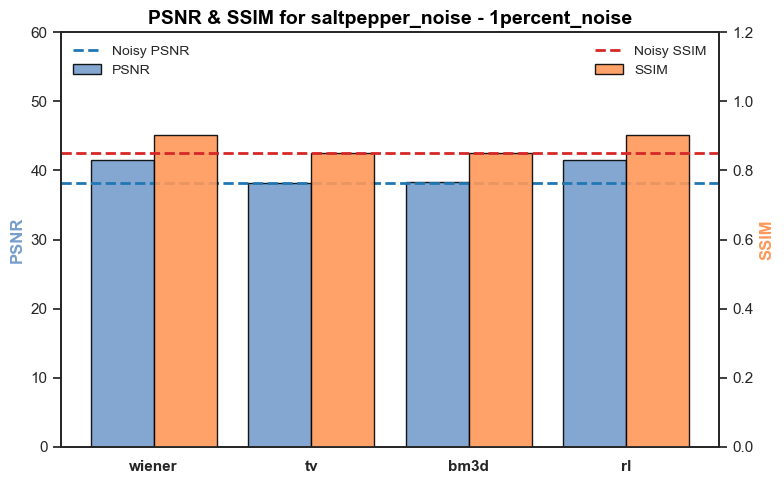

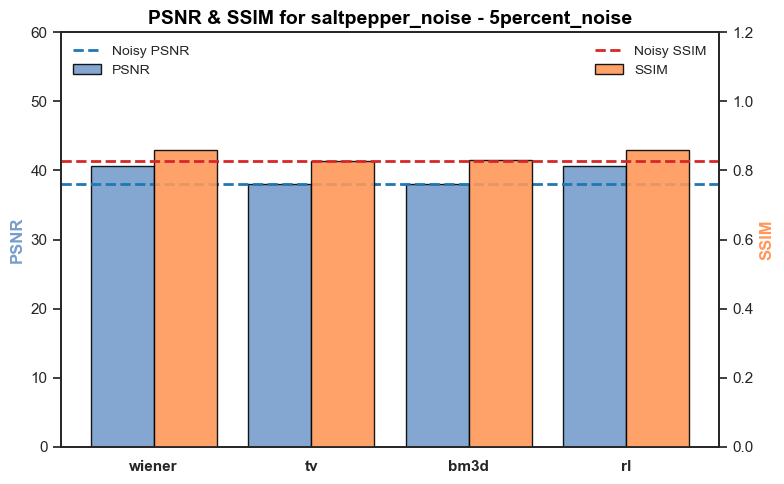

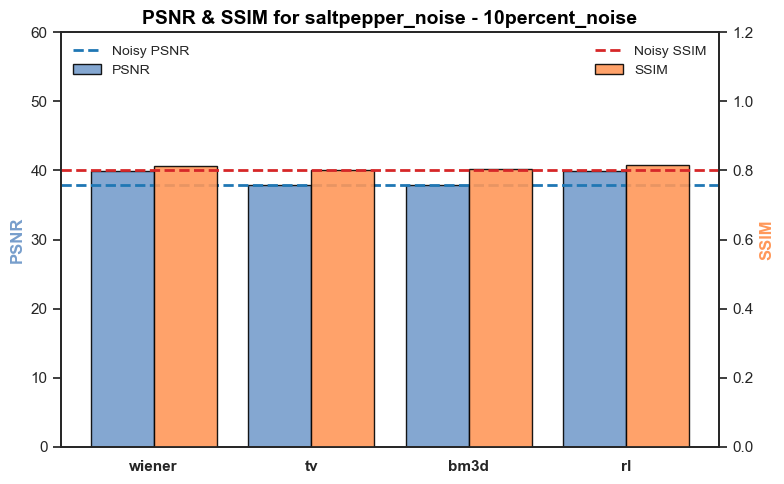

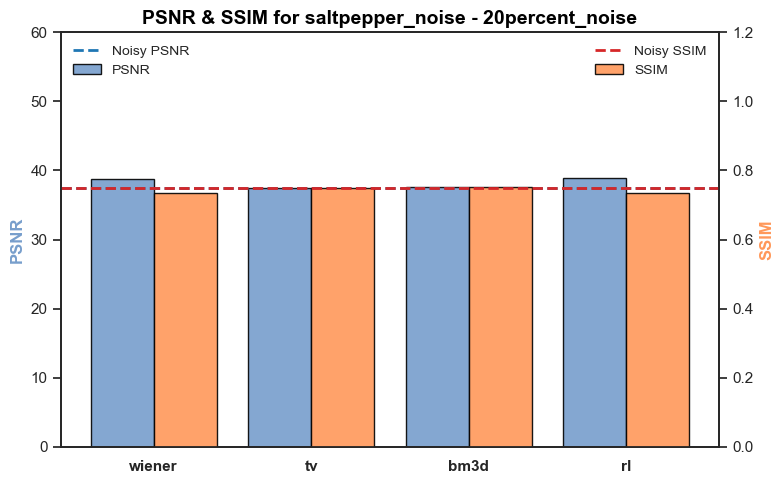

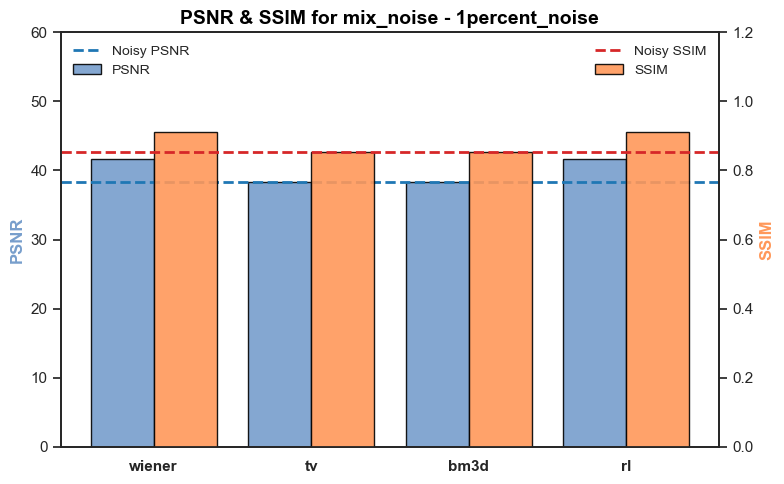

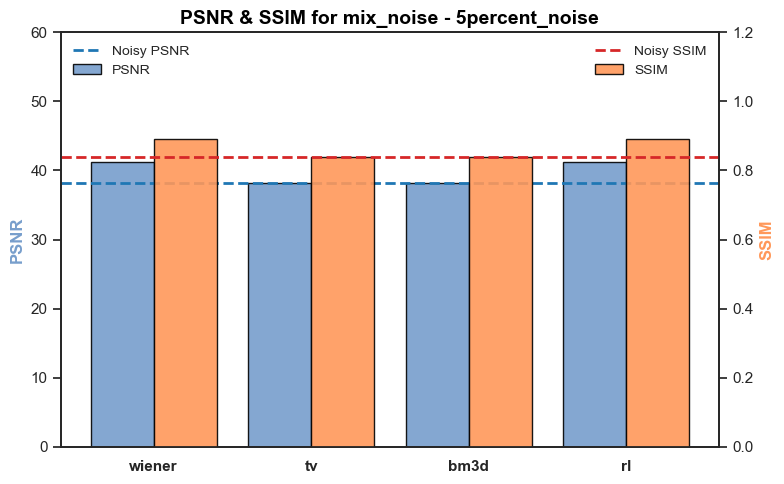

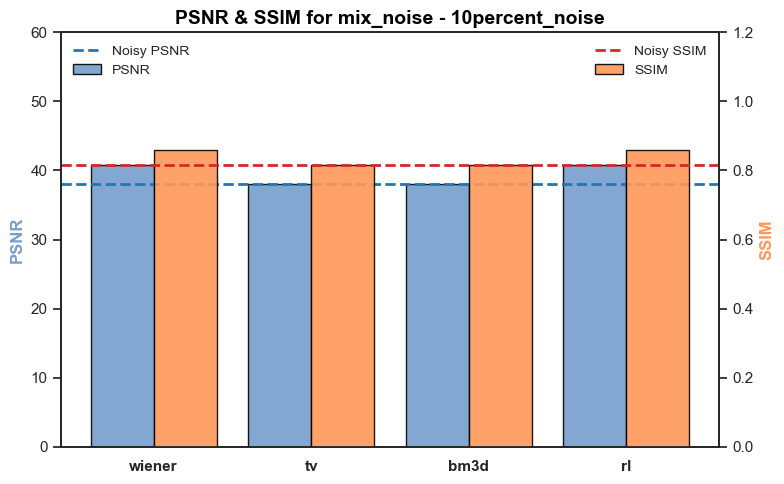

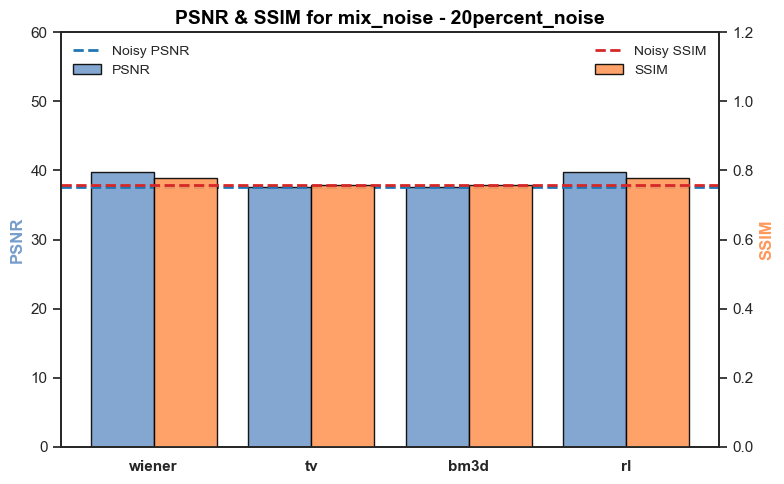

In [9]:
# Set Seaborn style for better aesthetics
sns.set(style="white")

# Define custom colors
psnr_color = "#779ECC"  # Modern blue
ssim_color = "#FF985A"  # Modern orange
noisy_psnr_color = "#1f77b4"  # Darker blue for noisy threshold
noisy_ssim_color = "#d62728"  # Dark red for noisy threshold

# Iterate over each noise type and intensity
for noise in df['Noise Type'].unique():
    for intensity in df['Intensity'].unique():
        # Filter data for the specific noise type and intensity
        sub_df = df[(df['Noise Type'] == noise) & (df['Intensity'] == intensity)]
        
        if sub_df.empty:
            continue  # Skip if no data
        
        # Extract noisy image PSNR and SSIM values for reference lines
        noisy_psnr = sub_df[sub_df['Filter'] == 'Noisy']['PSNR'].values[0]
        noisy_ssim = sub_df[sub_df['Filter'] == 'Noisy']['SSIM'].values[0]

        # Remove noisy row for bar plot
        sub_df = sub_df[sub_df['Filter'] != 'Noisy']

        # Create figure and axis
        fig, ax1 = plt.subplots(figsize=(8, 5))

        # Bar width and x positions
        bar_width = 0.4
        x = np.arange(len(sub_df['Filter']))

        # PSNR Bars (Left Y-axis)
        ax1.set_ylabel('PSNR', color=psnr_color, fontsize=12, fontweight='bold')
        ax1.set_ylim(0, 60)
        ax1.bar(x - bar_width / 2, sub_df['PSNR'], width=bar_width, color=psnr_color, label='PSNR', alpha=0.9, edgecolor="black", linewidth=1)

        # Noisy Image PSNR Threshold (Dotted Line)
        ax1.axhline(y=noisy_psnr, color=noisy_psnr_color, linestyle='dashed', linewidth=2, label='Noisy PSNR')

        # SSIM Bars (Right Y-axis)
        ax2 = ax1.twinx()
        ax2.set_ylabel('SSIM', color=ssim_color, fontsize=12, fontweight='bold')
        ax2.set_ylim(0, 1.2)
        ax2.bar(x + bar_width / 2, sub_df['SSIM'], width=bar_width, color=ssim_color, label='SSIM', alpha=0.9, edgecolor="black", linewidth=1)

        # Noisy Image SSIM Threshold (Dotted Line)
        ax2.axhline(y=noisy_ssim, color=noisy_ssim_color, linestyle='dashed', linewidth=2, label='Noisy SSIM')

        # X-axis labels
        ax1.set_xticks(x)
        ax1.set_xticklabels(sub_df['Filter'], fontsize=11, fontweight='bold')

        # Titles and legends
        plt.title(f'PSNR & SSIM for {noise} - {intensity}', fontsize=14, fontweight='bold', color="black")
        ax1.legend(loc='upper left', fontsize=10)
        ax2.legend(loc='upper right', fontsize=10)

        # Improve layout
        plt.tight_layout()

        # Save and show
        save_path = f'output_images/histograms/{noise}_{intensity}.png'
        os.makedirs(os.path.dirname(save_path), exist_ok=True)
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        plt.show()

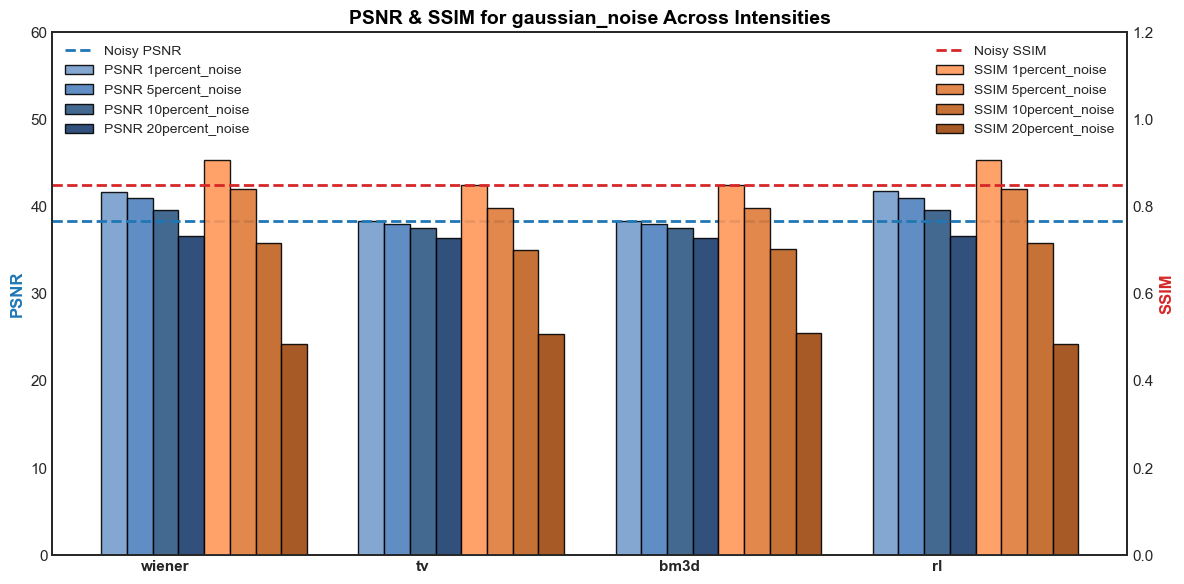

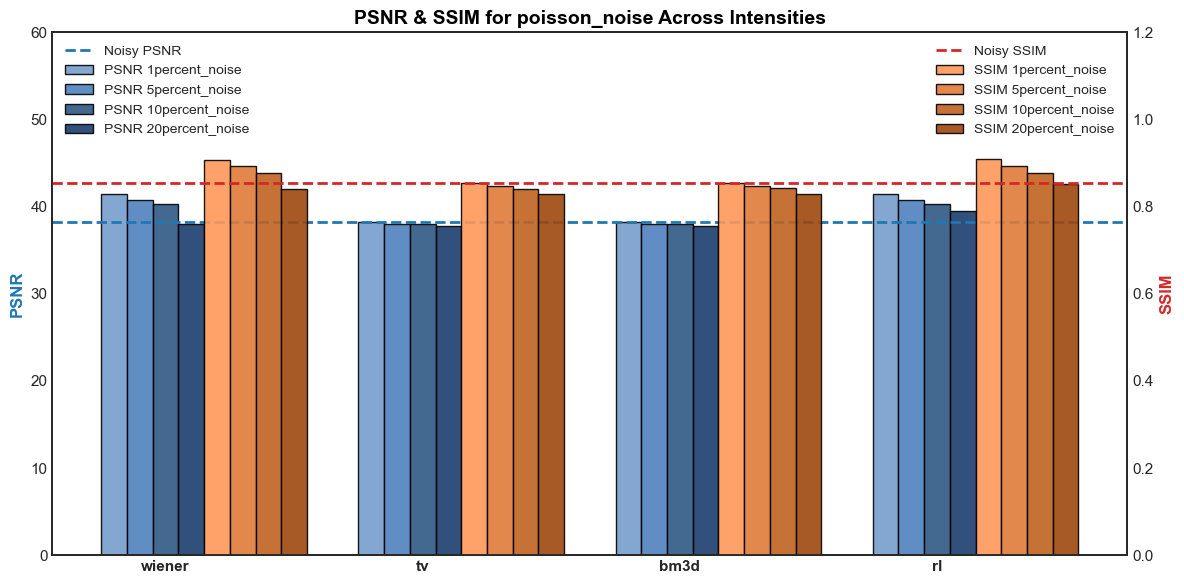

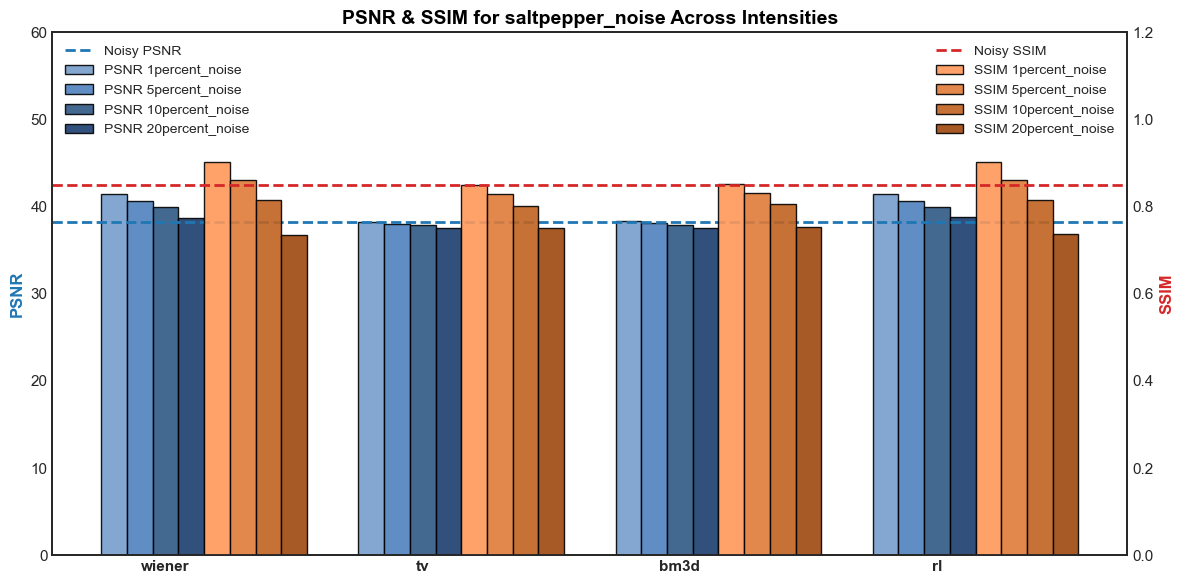

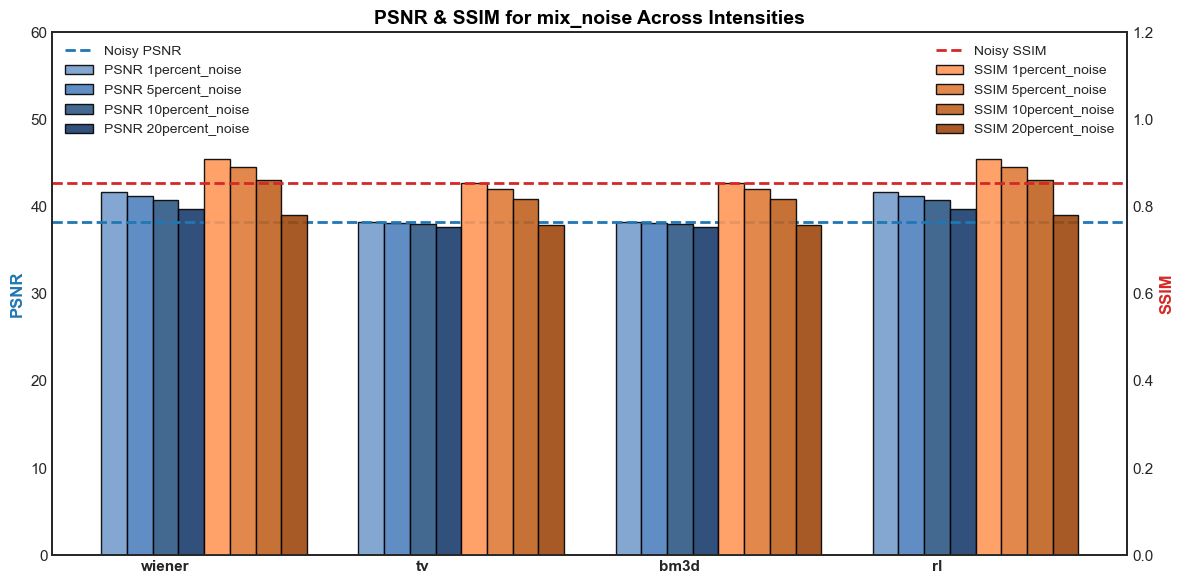

In [10]:
# Set plot style
plt.style.use("seaborn-v0_8-white")
# Define custom colors
psnr_colors = ["#779ECC", "#4F81BD", "#2E5984", "#1A3D6D"]  # Shades of blue for PSNR
ssim_colors = ["#FF985A", "#E07B39", "#C06321", "#9E480E"]  # Shades of orange for SSIM
noisy_psnr_color = "#1f77b4"  # Dark blue for noisy threshold
noisy_ssim_color = "#d62728"  # Dark red for noisy threshold

# Iterate over each noise type
for noise in df['Noise Type'].unique():
    filters = df['Filter'].unique()
    filters = [f for f in filters if f != "Noisy"]  # Exclude noisy from x-axis labels

    x = np.arange(len(filters))  # X positions for each filter
    bar_width = 0.1  # Narrower bars to fit all intensities

    fig, ax1 = plt.subplots(figsize=(12, 6))

    # Create twin y-axis
    ax2 = ax1.twinx()

    # Iterate over intensities
    for i, intensity in enumerate(df['Intensity'].unique()):
        # Filter data for specific intensity
        sub_df = df[(df['Noise Type'] == noise) & (df['Intensity'] == intensity)]
        
        if sub_df.empty:
            continue

        # Extract noisy PSNR & SSIM for reference lines
        noisy_psnr = sub_df[sub_df['Filter'] == 'Noisy']['PSNR'].values[0]
        noisy_ssim = sub_df[sub_df['Filter'] == 'Noisy']['SSIM'].values[0]

        # Remove noisy row for plotting
        sub_df = sub_df[sub_df['Filter'] != 'Noisy']

        # PSNR Bars (Left Y-axis)
        ax1.bar(x + (i - 2) * bar_width, sub_df['PSNR'], width=bar_width, color=psnr_colors[i], label=f'PSNR {intensity}', alpha=0.9, edgecolor="black")

        # SSIM Bars (Right Y-axis)
        ax2.bar(x + (i + 2) * bar_width, sub_df['SSIM'], width=bar_width, color=ssim_colors[i], label=f'SSIM {intensity}', alpha=0.9, edgecolor="black")

        # Reference lines (only for first iteration to avoid redundancy)
        if i == 0:
            ax1.axhline(y=noisy_psnr, color=noisy_psnr_color, linestyle='dashed', linewidth=2, label='Noisy PSNR')
            ax2.axhline(y=noisy_ssim, color=noisy_ssim_color, linestyle='dashed', linewidth=2, label='Noisy SSIM')

    # Y-axis settings
    ax1.set_ylabel('PSNR', color=noisy_psnr_color, fontsize=12, fontweight='bold')
    ax1.set_ylim(0, 60)
    
    ax2.set_ylabel('SSIM', color=noisy_ssim_color, fontsize=12, fontweight='bold')
    ax2.set_ylim(0, 1.2)

    # X-axis settings
    ax1.set_xticks(x)
    ax1.set_xticklabels(filters, fontsize=11, fontweight='bold')

    # Titles and legends
    plt.title(f'PSNR & SSIM for {noise} Across Intensities', fontsize=14, fontweight='bold', color="black")
    ax1.legend(loc='upper left', fontsize=10)
    ax2.legend(loc='upper right', fontsize=10)

    # Improve layout
    plt.tight_layout()

    # Save and show
    save_path = f'output_images/histograms/{noise}_comparison.png'
    os.makedirs(os.path.dirname(save_path), exist_ok=True)
    plt.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.show()